# Transfer Learning Without Data Augumentation

## Load Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

## Load Data

In [2]:
train_path = 'data/train'
valid_path = 'data/test'

In [3]:
IMAGE_SIZE = [200, 200]

In [5]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [8]:
image_files[1]

'data/train/food/1_611.jpg'

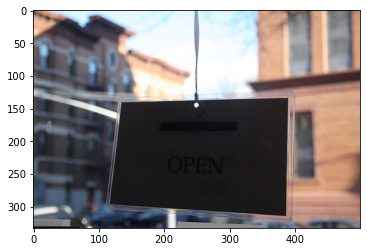

In [6]:
# Test random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Build Model

In [9]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE+[3],
    weights='imagenet',
    include_top=False
)

In [10]:
# map the data into feature vectors
# will still need to flatten, though we will not need any dense layers
x = Flatten()(ptm.output)

In [11]:
model = Model(inputs=ptm.input, outputs=x)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [13]:
# Create an instance of the ImageGenerator without data agumentation
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
batch_size = 128

train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
# create a numpy array to hold the transformed features using the pretrained model of our dataset

Ntrain = len(image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1]+IMAGE_SIZE+[3]))

D = feat.shape[1] # to get the number of transformed features

X_train = np.zeros((Ntrain,D))
Y_train = np.zeros((Ntrain))
X_valid = np.zeros((Nvalid,D))
Y_valid = np.zeros((Nvalid))

In [18]:
X_valid.shape

(1000, 18432)

In [19]:
# populate X_train and Y_train
# pass daatset through the pretrained model and get transformed features
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [20]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [21]:
# Logistic regression in TensorFlow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i,x)

In [22]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
r=linearmodel.fit(
    X_train,Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/10
24/24 [==============================] - 0s 7ms/step - loss: 4.4805e-06 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.9850
Epoch 2/10
24/24 [==============================] - 0s 5ms/step - loss: 4.1364e-06 - accuracy: 1.0000 - val_loss: 0.3027 - val_accuracy: 0.9850
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 3.7744e-06 - accuracy: 1.0000 - val_loss: 0.3029 - val_accuracy: 0.9850
Epoch 4/10
24/24 [==============================] - 0s 5ms/step - loss: 3.5265e-06 - accuracy: 1.0000 - val_loss: 0.3032 - val_accuracy: 0.9850
Epoch 5/10
24/24 [==============================] - 0s 5ms/step - loss: 3.2403e-06 - accuracy: 1.0000 - val_loss: 0.3034 - val_accuracy: 0.9850
Epoch 6/10
24/24 [==============================] - 0s 5ms/step - loss: 3.0450e-06 - accuracy: 1.0000 - val_loss: 0.3035 - val_accuracy: 0.9850
Epoch 7/10
24/24 [==============================] - 0s 5ms/step - loss: 2.8656e-06 - accuracy: 1.0000 - val_loss: 0.3037 - val_accuracy:

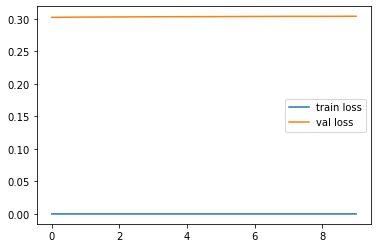

In [25]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

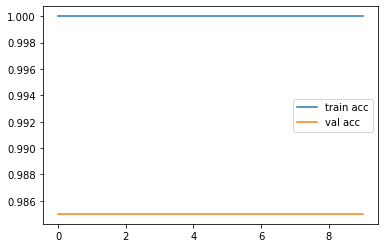

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [39]:
X_valid[0].shape

(18432,)

In [40]:
linearmodel.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 18432)]           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 18433     
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Test predictions 
linearmodel.predict(X_valid[[2]])

array([[0.]], dtype=float32)

In [44]:
# real Y
Y_valid[[2]]

array([0.])